# SVD based Downlink Precoding and Combining for Massive MIMO 5G Networks

SVD-based downlink precoding and combining for massive MIMO (Multiple Input Multiple Output) in 5G networks refers to a technique used to enhance the efficiency and performance of wireless communication systems, particularly in scenarios with a large number of antennas at the base station.
SVD stands for Singular Value Decomposition, a mathematical technique used to decompose a matrix into three other matrices, which helps in analyzing and manipulating the properties of the original matrix. 

- The first part of the SVD, known as left signular matrix, is used for signal **Combining** at the receiver,
- The third part of the SVD, known as left signular matrix, is used for signal **Precoding** at the transmitter,
- The middle part of the SVD, contains the eigen values which, is used for selection of rank.

In the context of downlink precoding and combining in massive MIMO systems, SVD is applied to the channel matrix to extract the spatial characteristics of the communication channels.

The tutorial is organized as following

- [Import Libraries](#Import-Python-Libraries)

    - [Import Python Libraries](#Import-Python-Libraries)
    - [Import 5G-Toolkit Libraries](#Import-5G-Toolkit-Libraries)
    
- [Simulation Parameters](#Simulation-Parameters)
- [Generate Wireless Channel: CDL-A](#Generate-Wireless-Channel:-CDL-A)
- [Link level simulation](#Link-level-simulation:-BLER/BER/Throughput/SE-vs-SNR-for-different-ranks)

**Key Performance Parameters**
- Throughput vs SNR
- BLER vs SNR
- BER vs SNR

## Import Python Libraries
### Import Python Libraries

In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

### Import 5G-Toolkit Libraries

In [2]:
import sys
sys.path.append("../../../")

from toolkit5G.PhysicalChannels.PDSCH import ComputeTransportBlockSize
from toolkit5G.PhysicalChannels       import PDSCHLowerPhy, PDSCHUpperPhy, PDSCHDecoderLowerPhy, PDSCHDecoderUpperPhy
from toolkit5G.ChannelModels          import AntennaArrays, SimulationLayout, ParameterGenerator, ChannelGenerator
from toolkit5G.Configurations         import PDSCHLowerPhyConfiguration, PDSCHUpperPhyConfiguration
from toolkit5G.ChannelProcessing      import AddNoise, ApplyChannel
from toolkit5G.SymbolMapping          import Mapper, Demapper

## Simulation Parameters

In [3]:

carrierFrequency = 3.6*10**9 # Carrier Frequency
numBatches   = 100           # Number of batches considered for simulation
scs          = 30*10**3      # Subcarrier Spacing for simulation
numBSs       = 1             # Number of BSs considered for simulation
# Number of UEs considered for simulation
numUEs       = numBatches    # For now we are assuming that the numbatches are captured via numUEs
numRB        = 20            # Number of Resource mapping considered for simulation | # 1 RB = 12 subcarrier
Nfft         = 256          # FFTSize
slotNumber   = 0             # Index of the slot considered for simulation
terrain      = "CDL-A"         # Terrain

txAntStruture = np.array([1,1,4,4,2]) # Tx Antenna Structure
rxAntStruture = np.array([1,1,2,2,2]) # Rx Antenna Structure

print("************ Simulation Parameters *************")
print()
print("     numBatches: "+str(numBatches))
print("          numRB: "+str(numRB))
print("       fft Size: "+str(Nfft))
print("         numBSs: "+str(numBSs))
print("         numUEs: "+str(numUEs))
print("            scs: "+str(scs))
print("     slotNumber: "+str(slotNumber))
print("        terrain: "+str(terrain))
print("Tx Ant Struture: "+str(txAntStruture))
print("Rx Ant Struture: "+str(rxAntStruture))
print()
print("********************************************")

************ Simulation Parameters *************

     numBatches: 100
          numRB: 20
       fft Size: 256
         numBSs: 1
         numUEs: 100
            scs: 30000
     slotNumber: 0
        terrain: CDL-A
Tx Ant Struture: [1 1 4 4 2]
Rx Ant Struture: [1 1 2 2 2]

********************************************


## Generate Wireless Channel: CDL-A

The process of channel generation is as follows:

- Generate Antenna Arrays

    - Generate Antenna Arrays for BSs
    - Generate Antenna Arrays for UEs
    
- Generate Simulation Topology
- Generate Propagation parameters (LSPs | SSPs | Intial random phases)
- Generate Wireless Channel ==> Get OFDM Channel


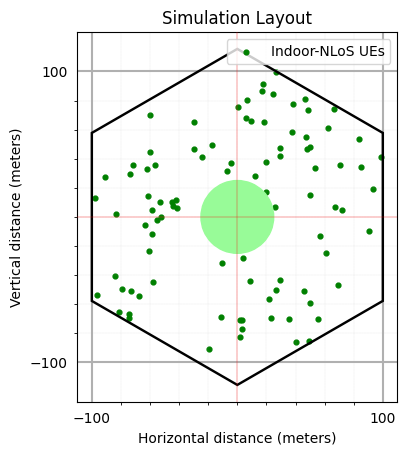

             Number of BSs: 1
          Shape of Channel: (1, 1, 1, 100, 256, 8, 32)
*****************************************************



In [4]:
# Antenna Array at UE side
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.
ueAntArray = AntennaArrays(antennaType = "OMNI",  centerFrequency = carrierFrequency, 
                           arrayStructure  = rxAntStruture)
ueAntArray()

# # Radiation Pattern of Rx antenna element 
# ueAntArray.displayAntennaRadiationPattern()


# Antenna Array at BS side
# assuming antenna element type to be "3GPP_38.901", a parabolic antenna 
# with 4 panel and 4 single polarized antenna element per panel.
bsAntArray = AntennaArrays(antennaType = "3GPP_38.901", centerFrequency = carrierFrequency,
                           arrayStructure  = txAntStruture)
bsAntArray()
    
# # Radiation Pattern of Tx antenna element 
# bsAntArray[0].displayAntennaRadiationPattern()

# Layout Parameters
isd                  = 200         # inter site distance
minDist              = 10          # min distance between each UE and BS 
ueHt                 = 1.5         # UE height
bsHt                 = 25          # BS height
bslayoutType         = "Hexagonal" # BS layout type
ueDropType           = "Hexagonal" # UE drop type
htDist               = "equal"     # UE height distribution
ueDist               = "equal"     # UE Distribution per site
nSectorsPerSite      = 1           # number of sectors per site
maxNumFloors         = 1           # Max number of floors in an indoor object
minNumFloors         = 1           # Min number of floors in an indoor object
heightOfRoom         = 3           # height of room or ceiling in meters
indoorUEfract        = 0.5         # Fraction of UEs located indoor
lengthOfIndoorObject = 3           # length of indoor object typically having rectangular geometry 
widthOfIndoorObject  = 3           # width of indoor object
# forceLOS             = True       # boolen flag if true forces every link to be in LOS state
forceLOS             = False       # boolen flag if true forces every link to be in LOS state

# simulation layout object                                 
simLayoutObj = SimulationLayout(numOfBS = numBSs,
                                numOfUE = numUEs,
                                heightOfBS = bsHt,
                                heightOfUE = ueHt, 
                                ISD = isd,
                                layoutType = bslayoutType,
                                ueDropMethod = ueDropType, 
                                UEdistibution = ueDist,
                                UEheightDistribution = htDist,
                                numOfSectorsPerSite = nSectorsPerSite,
                                ueRoute = None)

simLayoutObj(terrain = terrain, 
             carrierFreq = carrierFrequency, 
             ueAntennaArray = ueAntArray,
             bsAntennaArray = bsAntArray,
             indoorUEfraction = indoorUEfract,
             lengthOfIndoorObject = lengthOfIndoorObject,
             widthOfIndoorObject = widthOfIndoorObject,
             forceLOS = forceLOS)

# displaying the topology of simulation layout
fig, ax = simLayoutObj.display2DTopology()

paramGen = simLayoutObj.getParameterGenerator()

# paramGen.displayClusters((0,0,0), rayIndex = 0)
channel = paramGen.getChannel()
Hf      = channel.ofdm(scs, Nfft, normalizeChannel = True)

Nt        = bsAntArray.numAntennas # Number of BS Antennas
Nr        = ueAntArray.numAntennas

print("             Number of BSs: "+str(numBSs))
print("          Shape of Channel: "+str(Hf.shape))
print("*****************************************************")
print()

## Link level simulation: BLER/BER/Throughput/SE vs SNR for different ranks

The simulation flow is listed below. The flow is repeated for each rank value.


- Generate PDSCH Configurations/parameters
- Pass the transport block though upper PDSCH chain ==> Generate the codeword.
- Pass the codeword through the lower PDSCH chain ==> Generate the transmission grid.
- Compute the Precoder and Combiner for the batches.
- Precode/Beamform the transmission grid
- Pass the beamformed grid through the wireless channel
- Add noise to the received grid
- MIMO combining at the receiver.
- Receiver Lower PDSCH chain processing.
- Receiver Upper PDSCH chain processing.
- Compute the KPIs.


In [5]:
ranks      = np.array([1,2,4,8])
numPoints  = 10

SNRdB      = np.array([np.linspace(-13,-4, numPoints),
                       np.linspace( -8, 0, numPoints),
                       np.linspace( -3,-1, numPoints),
                       np.linspace(  2, 8, numPoints)])

SNR        = 10**(SNRdB/10)

codedBER   = np.zeros((ranks.size, numPoints))
uncodedBER = np.zeros((ranks.size, numPoints))
bler       = np.zeros((ranks.size, numPoints))
throughput = np.zeros((ranks.size, numPoints))


for r in range(ranks.size):
    
    ########################################## PDSCH Lower Physical Layer Parameters #########################################
    pdschLowerPhyConfig    = PDSCHLowerPhyConfiguration(rank = ranks[r], startSymbol=0, numSymbols=10, pdschMappingType = "PDSCH-mapping-type-A", 
                                                        maxLength = "len2", dmrsAdditionalPosition = "pos1",
                                                        configurationType = "Configuration-type-1", verbose = False)
    pdschMappingType       = pdschLowerPhyConfig.pdschMappingType   # "PDSCH mapping type A" or "PDSCH mapping type B"
    maxLength              = pdschLowerPhyConfig.maxLength
    startSymbol            = pdschLowerPhyConfig.startSymbol
    numSymbols             = pdschLowerPhyConfig.numSymbols
    betaDMRS               = pdschLowerPhyConfig.betaDMRS
    configurationType      = pdschLowerPhyConfig.configurationType   # "Configuration-type-1" or "Configuration-type-2"
    dmrsTypeAPosition      = pdschLowerPhyConfig.dmrsTypeAPosition                                   # "pos2" or "pos3"
    dmrsAdditionalPosition = pdschLowerPhyConfig.dmrsAdditionalPosition  # "pos2" or "pos3"
    ld                     = pdschLowerPhyConfig.ld
    l0                     = pdschLowerPhyConfig.l0
    l1                     = pdschLowerPhyConfig.l1
    rank                   = pdschLowerPhyConfig.rank
    scramblingID           = pdschLowerPhyConfig.scramblingID
    nSCID                  = pdschLowerPhyConfig.nSCID

    mcsIndex               = 7
    mcsTable               = "pdschTable1"

    ########################################## PDSCH Parameters #########################################
    pdschUpperPhyConfig    = PDSCHUpperPhyConfiguration(pdschMappingType = pdschMappingType, configurationType = configurationType, 
                                                        dmrsTypeAPosition = dmrsTypeAPosition, maxLength = maxLength, mcsIndex = mcsIndex,
                                                        mcsTable = mcsTable, dmrsAdditionalPosition = dmrsAdditionalPosition, l0 = l0, 
                                                        ld = ld, l1 = l1, startSymbol = startSymbol, numSymbols = numSymbols, rank = rank, 
                                                        numRB = numRB, verbose = False)

    numTBs                 = pdschUpperPhyConfig.numTBs
    numRB                  = pdschUpperPhyConfig.numRB
    tbLen1                 = pdschUpperPhyConfig.tbLen1

    codeRate               = pdschUpperPhyConfig.codeRate
    modOrder               = pdschUpperPhyConfig.modOrder
    mcsIndex               = pdschUpperPhyConfig.mcsIndex
    mcsTable               = pdschUpperPhyConfig.mcsTable
    numlayers              = pdschUpperPhyConfig.numlayers
    scalingField           = pdschUpperPhyConfig.scalingField
    additionalOverhead     = pdschUpperPhyConfig.additionalOverhead
    dmrsREs                = pdschUpperPhyConfig.dmrsREs
    additionalOverhead     = pdschUpperPhyConfig.additionalOverhead

    numTargetBits1         = pdschUpperPhyConfig.numTargetBits1
    if(numTBs == 2):
        numTargetBits1     = pdschUpperPhyConfig.numTargetBits1
        numTargetBits2     = pdschUpperPhyConfig.numTargetBits2
        tbLen2             = pdschUpperPhyConfig.tbLen2

    numTargetBits          = pdschUpperPhyConfig.numTargetBits
    
    

    pdschUpperPhy = PDSCHUpperPhy(symbolsPerSlot = numSymbols, numRB = numRB, mcsIndex = mcsIndex, 
                                  numlayers = numlayers, scalingField = scalingField, 
                                  additionalOverhead = additionalOverhead, dmrsREs = dmrsREs, 
                                  numTBs=numTBs, pdschTable = mcsTable, verbose = False)

    codeword      = pdschUpperPhy(tblock = [None, None], rvid = [0, 0], enableLBRM = [False, False], 
                                  numBatch = numBatches, numBSs = numBSs)

    rnti         = np.random.randint(65536, size=numBSs*numBatches)
    nID          = np.random.randint(1024,  size=numBSs*numBatches)
    bits2        = codeword[1] if numTBs == 2 else None

    pdschLowerPhyChain = PDSCHLowerPhy(pdschMappingType, configurationType, dmrsTypeAPosition, 
                                       maxLength, dmrsAdditionalPosition, l0, ld, l1)
    resourceGrid  = pdschLowerPhyChain(codeword[0], numRB, rank, slotNumber, scramblingID, 
                                        nSCID, rnti, nID, modOrder, startSymbol, bits2 = bits2)

    ## Load the resource Grid into the transmision Grid
    txGrid        = np.zeros(resourceGrid.shape[0:-1]+(Nfft,), dtype= np.complex64)
    bwpOffset     = np.random.randint(Nfft-numRB*12)
    txGrid[...,bwpOffset:bwpOffset+numRB*12] = resourceGrid

    # Digital Beamforming
    [U, S, Vh] = np.linalg.svd(Hf)
    precoder   = np.conj(Vh.transpose(3,0,1,2,4,6,5)[...,0:rank])
    combiner   = np.conj((U*(1/S[...,np.newaxis,:].repeat(S.shape[-1], axis = -2)))[...,0:rank].transpose(3,0,1,2,4,6,5))
    xBeam      = (precoder@txGrid.transpose(0,1,3,4,2)[:,np.newaxis,...,np.newaxis])[...,0]

    ptc = ApplyChannel(isFrequencyDomain = True, enableInterTxInterference = True, memoryConsumptionLevel = 0)
    y   = ptc(Hf[np.newaxis].transpose(4,0,1,2,3,5,6,7), xBeam.transpose(0,1,3,2,4,5))


    for i in range(numPoints):
        print("********************************************************")
        print("Simulation: ["+str(i)+"] for      SNRdB = "+str(SNRdB[r,i]))

        ## Add noise to the received grid
        yGrid = AddNoise(False)(y, 1/SNR[r,i], 0)

        ## Receiver Combining
        rGrid = ((combiner@yGrid[...,np.newaxis])[:,0,...,0]).transpose(0,2,4,1,3)

        ## Extracting the Received Grid
        rxGrid = rGrid[...,bwpOffset:bwpOffset+12*numRB]

        ## Receiver: Lower Physical layer
        isChannelPerfect = False
        pdschDecLowerPhy = PDSCHDecoderLowerPhy(modOrder, isChannelPerfect, isEqualized = True)
        descrBits        = pdschDecLowerPhy(rxGrid, pdschLowerPhyChain.pdschIndices, rnti, 
                                            nID, SNR[r,i], None, numTBs, hard_out = False)
        
        if rank == 8:
            temp1 = descrBits[0]
            temp2 = descrBits[1]
            temp1 = np.where(temp1> 20,  20, temp1)
            temp1 = np.where(temp1<-20, -20, temp1)
            temp2 = np.where(temp2> 20,  20, temp2)
            temp2 = np.where(temp2<-20, -20, temp2)
            descrBits = (temp1,temp2)
        elif rank == 4:
            temp1 = descrBits[0]
            temp1 = np.where(temp1> 20,  20, temp1)
            temp1 = np.where(temp1<-20, -20, temp1)
            descrBits = (temp1,)
            
            
        ## Receiver: Upper Physical layer
        pdschUpPhyDec = PDSCHDecoderUpperPhy(numTBs = numTBs, mcsIndex = mcsIndex, symbolsPerSlot= numSymbols, 
                                             numRB = numRB, numLayers = numlayers, scalingField = scalingField, 
                                             additionalOverhead = additionalOverhead, dmrsREs = dmrsREs, 
                                             enableLBRM = [False, False], pdschTable = mcsTable, rvid = [0, 0], verbose=False)

        bits          = pdschUpPhyDec(descrBits)

        if numTBs == 1:
            ## KPI computation
            codedBER[r,i]   = np.mean(np.abs(bits[0]-pdschUpperPhy.tblock1))
            bler[r,i]       = 1 - np.mean(pdschUpPhyDec.crcCheckforCBs)
            throughput[r,i] = (1 - bler[r,i])*tbLen1*2000

        else:
            ## KPI computation
            codedBER[r,i]   = np.mean(np.abs(np.concatenate([bits[0], bits[1]], axis=-1) - np.concatenate([pdschUpperPhy.tblock1, pdschUpperPhy.tblock2], axis=-1)))
            bler[r,i]       = 1 - np.mean(pdschUpPhyDec.crcCheckforCBs)
            throughput[r,i] = (1 - bler[r,i])*(tbLen1 + tbLen2)*2000
            
        print("Simulation: "+str([r,i])+" for       BLER = "+str(bler[r,i]))
        print("Simulation: "+str([r,i])+" for Throughput = "+str(throughput[r,i]))

        print("********************************************************")
        print()



********************************************************
Simulation: [0] for      SNRdB = -13.0
Simulation: [0, 0] for       BLER = 1.0
Simulation: [0, 0] for Throughput = 0.0
********************************************************

********************************************************
Simulation: [1] for      SNRdB = -12.0
Simulation: [0, 1] for       BLER = 1.0
Simulation: [0, 1] for Throughput = 0.0
********************************************************

********************************************************
Simulation: [2] for      SNRdB = -11.0
Simulation: [0, 2] for       BLER = 0.86
Simulation: [0, 2] for Throughput = 566720.0
********************************************************

********************************************************
Simulation: [3] for      SNRdB = -10.0
Simulation: [0, 3] for       BLER = 0.32999999999999996
Simulation: [0, 3] for Throughput = 2712160.0000000005
********************************************************

**************************

Simulation: [3, 3] for       BLER = 1.0
Simulation: [3, 3] for Throughput = 0.0
********************************************************

********************************************************
Simulation: [4] for      SNRdB = 4.666666666666666
Simulation: [3, 4] for       BLER = 0.775
Simulation: [3, 4] for Throughput = 5299200.0
********************************************************

********************************************************
Simulation: [5] for      SNRdB = 5.333333333333333
Simulation: [3, 5] for       BLER = 0.0050000000000000044
Simulation: [3, 5] for Throughput = 23434240.0
********************************************************

********************************************************
Simulation: [6] for      SNRdB = 6.0
Simulation: [3, 6] for       BLER = 0.0
Simulation: [3, 6] for Throughput = 23552000.0
********************************************************

********************************************************
Simulation: [7] for      SNRdB = 6.666666

## Simulation Results

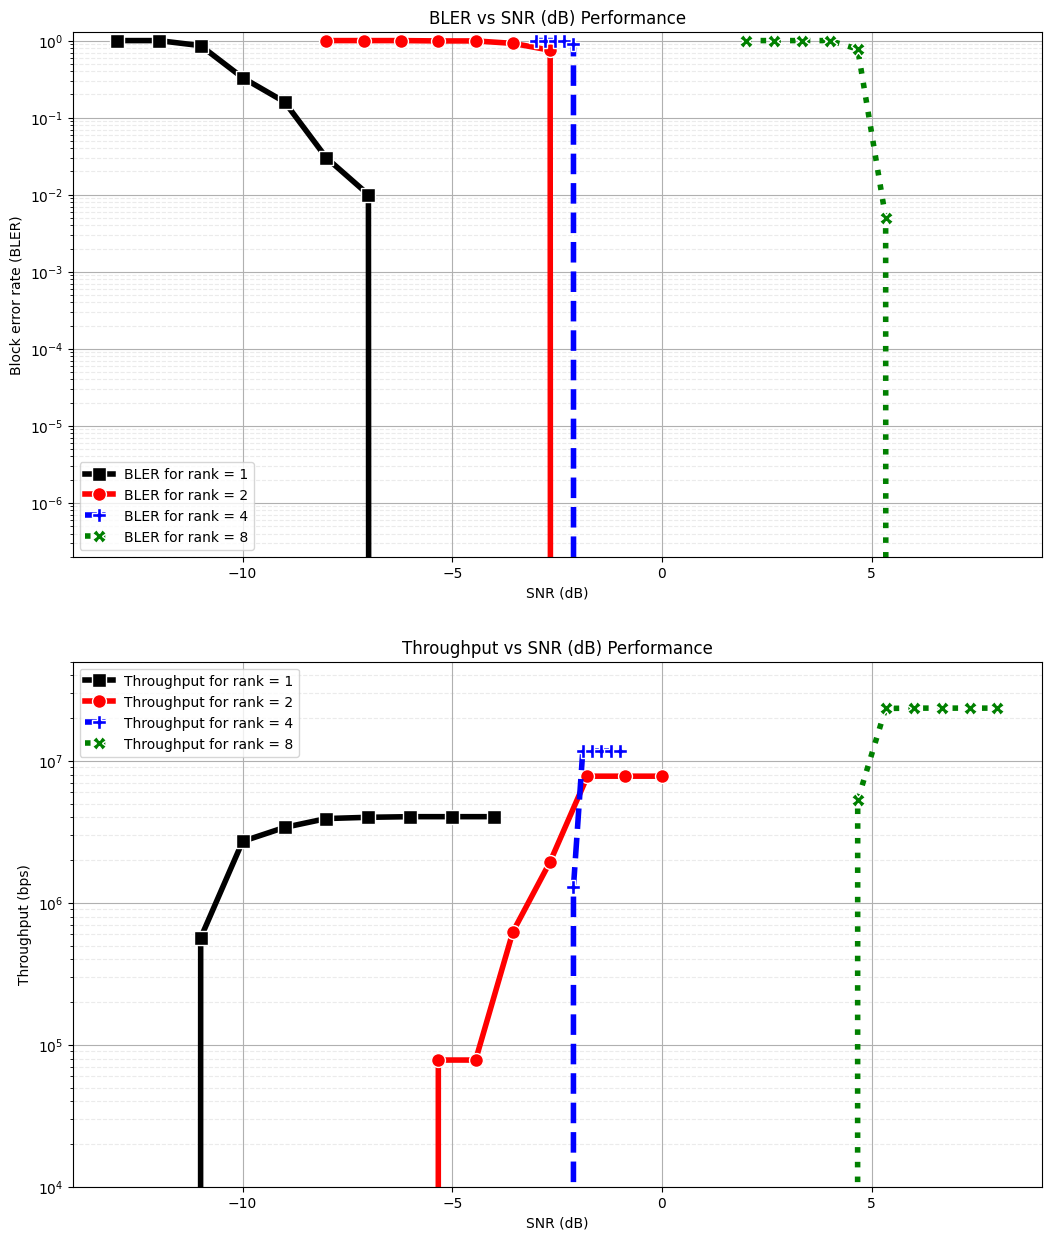

In [6]:
                
fig, ax = plt.subplots(2,1, figsize = (12.5, 15))

ls1     = [":r", ":r", ":r", ":r"]
ls2     = ["--g", "--g", "--g", "--g"]
ls3     = ["k", "-r", "--b", ":g"]
markers = ["s", "o", "P", "X"]

for r in range(ranks.size):
    
#     ax[0].semilogy(SNRdB[r], codedBER[r],   ls1[r], marker = markers[r], ms = 10, lw = 3.5, mec = "white", label="codedBER-"+str(ranks[r]))
    ax[0].semilogy(SNRdB[r], bler[r],       ls3[r], marker = markers[r], ms = 10, lw = 4, mec = "white", label="BLER for rank = "+str(ranks[r]))
    
    ax[1].semilogy(SNRdB[r], throughput[r], ls3[r], marker = markers[r], ms = 10, lw = 4, mec = "white", label="Throughput for rank = "+str(ranks[r]))

ax[0].legend(loc="best")
ax[1].legend(loc="best")

ytck = (0.1**(np.arange(1, 8))).repeat(9)*np.tile(np.arange(10, 1,-1), [7])
ytck = np.concatenate([[1],ytck])
ax[0].set_yticks(ytck, minor=True)
ax[0].set_yticks(0.1**(np.arange(0, 7)), minor=False)
ax[0].set_ylim([2*10**-4, 1.2])

ax[0].grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax[0].grid(which = 'major', alpha = 1)

ax[0].set_xlabel("SNR (dB)")
ax[0].set_ylabel("Block error rate (BLER)")
ax[0].set_title("BLER vs SNR (dB) Performance")

ytck = 10**(np.arange(4, 9)).repeat(9)*np.tile(np.arange(1, 10), [5])
ax[1].set_yticks(ytck, minor=True)
ax[1].set_yticks(10**(np.arange(4, 8)), minor=False)
ax[1].set_ylim([10**4, 0.3*10**8])
ax[1].grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax[1].grid(which = 'major', alpha = 1)

ax[1].set_xlabel("SNR (dB)")
ax[1].set_ylabel("Throughput (bps)")
ax[1].set_title("Throughput vs SNR (dB) Performance")

plt.show()

## Simulation Results: Averaged over 10000 batches

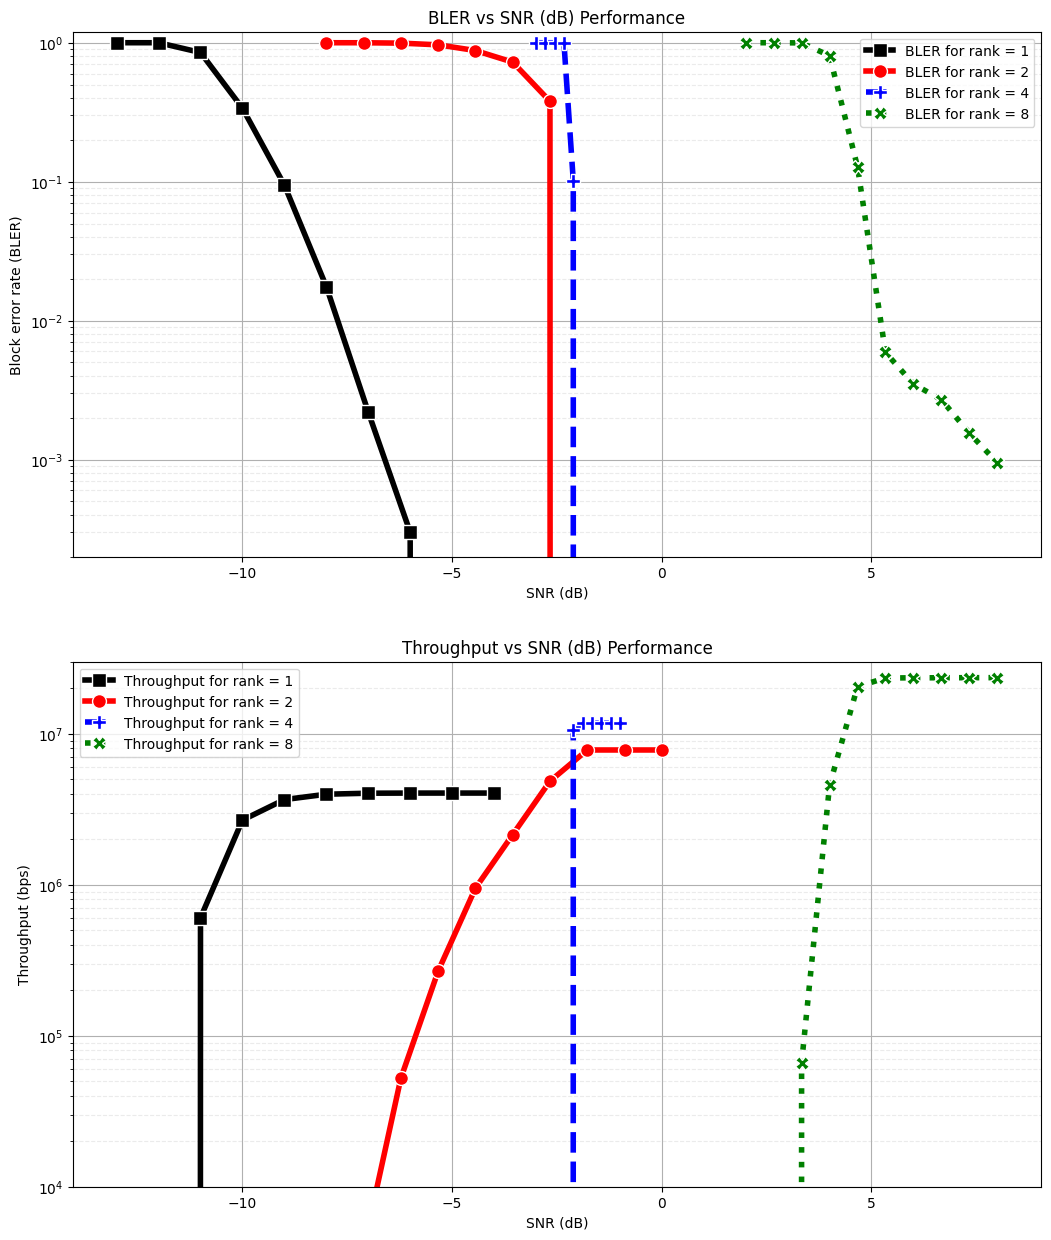

In [8]:

filename    = "Databases/MIMO-[0].npz"
dB          = np.load(filename)
SNRdBa      = dB["SNRdB"]
codedBERa   = dB["codedBER"]
blera       = dB["bler"]
throughputa = dB["throughput"]
xticksa     = np.linspace(-11, -4, 10)
ranks       = np.array([1,2,4,8])

numDBs      = 10
for i in range(1,numDBs):
    filename    = "Databases/MIMO-"+str([i])+".npz"
    dB          = np.load(filename)
    codedBERa   = codedBERa   + dB["codedBER"]
    blera       = blera       + dB["bler"]
    throughputa = throughputa + dB["throughput"]

codedBERa   = codedBERa/numDBs
blera       = blera/numDBs
throughputa = throughputa/numDBs
    
fig, ax = plt.subplots(2,1, figsize = (12.5, 15))

ls1     = [":r", ":r", ":r", ":r"]
ls2     = ["--g", "--g", "--g", "--g"]
ls3     = ["k", "-r", "--b", ":g"]
markers = ["s", "o", "P", "X"]

for r in range(ranks.size):
    
#     ax[0].semilogy(SNRdBa[r], codedBERa[r],   ls1[r], marker = markers[r], ms = 10, lw = 3.5, mec = "white", label="codedBER-"+str(ranks[r]))
    ax[0].semilogy(SNRdBa[r], blera[r],       ls3[r], marker = markers[r], ms = 10, lw = 4, mec = "white", label="BLER for rank = "+str(ranks[r]))
    
    ax[1].semilogy(SNRdBa[r], throughputa[r], ls3[r], marker = markers[r], ms = 10, lw = 4, mec = "white", label="Throughput for rank = "+str(ranks[r]))

ax[0].legend(loc="best")
ax[1].legend(loc="best")

ytck = (0.1**(np.arange(1, 8))).repeat(9)*np.tile(np.arange(10, 1,-1), [7])
ytck = np.concatenate([[1],ytck])
ax[0].set_yticks(ytck, minor=True)
ax[0].set_yticks(0.1**(np.arange(0, 7)), minor=False)
ax[0].set_ylim([2*10**-4, 1.2])

ax[0].grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax[0].grid(which = 'major', alpha = 1)

ax[0].set_xlabel("SNR (dB)")
ax[0].set_ylabel("Block error rate (BLER)")
ax[0].set_title("BLER vs SNR (dB) Performance")

ytck = 10**(np.arange(4, 9)).repeat(9)*np.tile(np.arange(1, 10), [5])
ax[1].set_yticks(ytck, minor=True)
ax[1].set_yticks(10**(np.arange(4, 8)), minor=False)
ax[1].set_ylim([10**4, 0.3*10**8])
ax[1].grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax[1].grid(which = 'major', alpha = 1)

ax[1].set_xlabel("SNR (dB)")
ax[1].set_ylabel("Throughput (bps)")
ax[1].set_title("Throughput vs SNR (dB) Performance")

plt.show()